# Logistic regression example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pystan

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})
figpath='../doc/fig/'

In [2]:
############################
############################
##    data generation     ##
############################
############################

# settings
np.random.seed(520)
N = 100 
true_beta = np.array([2.,3.])

# create data matrix
X = np.ones((N,2))
X[:,1] = -1.+1.5*np.random.randn(N)

# create response variable
eta = X.dot(true_beta)
true_p = 1./(1+np.exp(-eta))
Y = np.random.binomial(1,true_p,N)

Text(0.5, 1.0, 'Response $y$ and probability as function of $\\beta_1$')

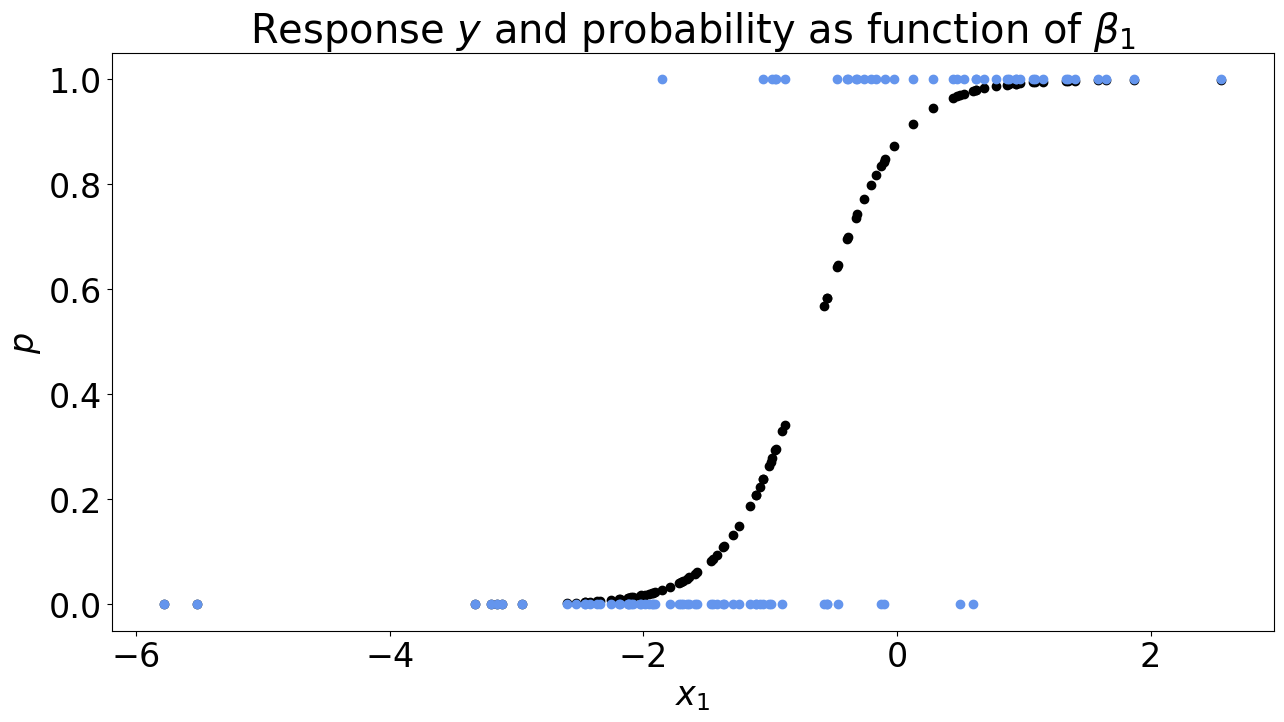

In [3]:
plt.scatter(X[:,1],true_p,c='black')
plt.scatter(X[:,1],Y,c='cornflowerblue')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$p$')
plt.title(r'Response $y$ and probability as function of $\beta_1$')

### Unnormalized posterior plot

In [54]:
# gaussian log density
def gauss_lp(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*logsigma-0.5*np.log(2*np.pi)

In [55]:
############################
############################
## posterior distribution ##
############################
############################
#altY=np.maximum(1e-5,np.minimum(1-1e-5,Y))[:,np.newaxis] # to be able to take logarithms
prbs = lambda beta : 1./(1.+np.exp(-true_beta[0]-beta[:,np.newaxis]*X[:,1]))
ll = lambda beta : np.sum(Y*np.log(prbs(beta))+(1-Y)*np.log(1-prbs(beta)),axis=1)
lprior = lambda beta : gauss_lp(beta,0.,np.log(30.))
lp = lambda beta : ll(beta)+lprior(beta) # target p(x,z)

Text(0, 0.5, 'Unnormalized density')

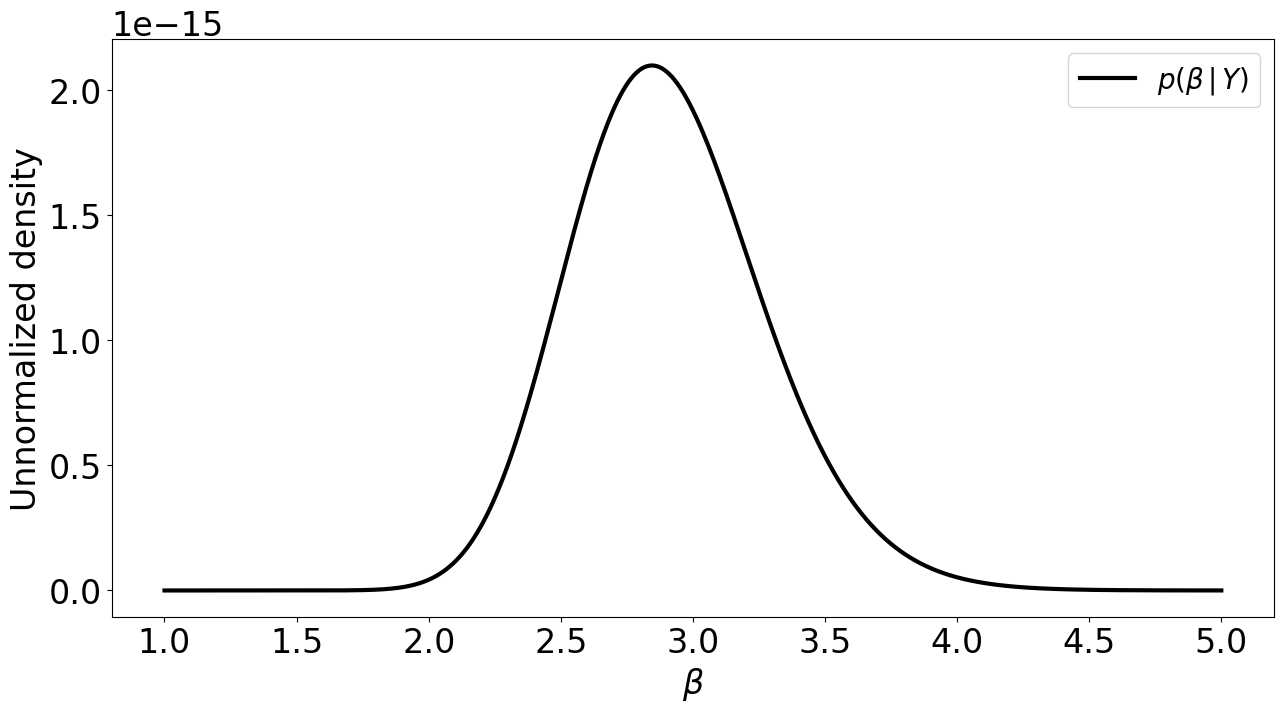

In [56]:
ls=np.linspace(1,5,10000)
target=np.exp(lp(ls))
#target=target/np.sum(target)
plt.plot(ls,target,color='black',lw=3,label=r'$p(\beta\,|\,Y)$')
plt.legend(fontsize='small')
plt.xlabel(r'$\beta$')
plt.ylabel('Unnormalized density')

## Fit model with Stan

In [4]:
# model definition
stan_code = """
data {
  int<lower=0> n; // number of observations
  int y[n]; // responses
  vector[n] x1; // predictors
  real beta0; // intercept
}
parameters {
  real beta1;
}
model {
  beta1 ~ normal(0, 30);
  y ~ bernoulli_logit(beta0+beta1*x1);
}
"""

In [5]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_885816be3a6e229f8e2d0b5893720007 NOW.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/24

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:37

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

164 warnings generated.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_8858

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:37

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:846:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long lon

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

163 warnings generated.
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'


In [6]:
# run in stan
stan_data = {'n': N,
             'y': Y,
             'x1': X[:,1],
             'beta0': true_beta[0]}
fit = model.sampling(data=stan_data, iter=10000, chains=1)


Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.078506 seconds (Warm-up)
               0.085184 seconds (Sampling)
               0.16369 seconds (Total)



In [7]:
# summary statistics
print(fit.stansummary(pars=['beta1']))
samples = fit.extract()

Inference for Stan model: anon_model_885816be3a6e229f8e2d0b5893720007.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   2.92  8.3e-3   0.36   2.26   2.67    2.9   3.14   3.69   1920    1.0

Samples were drawn using NUTS at Wed Apr 19 16:40:36 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


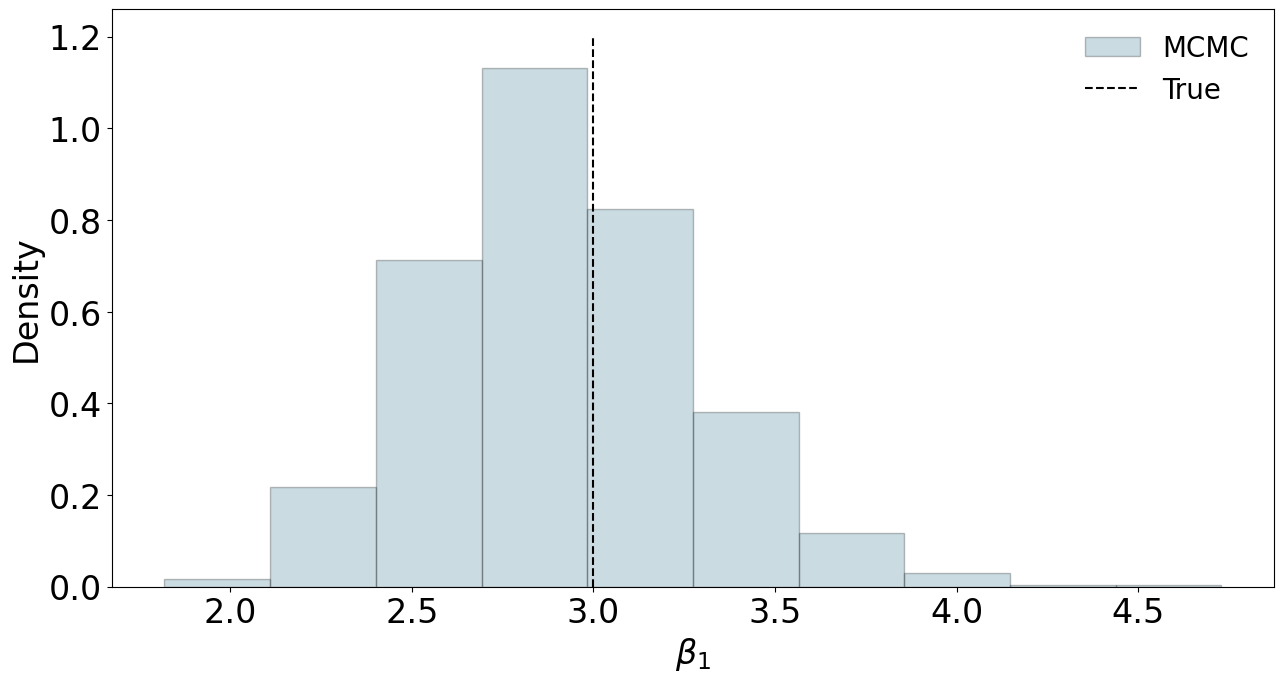

In [8]:
plt.hist(samples['beta1'], color='#2D718EFF',ec='black',alpha=0.25,label='MCMC',density=True)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label='True')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
#for lh in leg.legendHandles: lh.set_alpha(1)
#plt.savefig(fig_path+'logreg_mcmc_scatter.pdf', dpi=300, bbox_inches='tight')

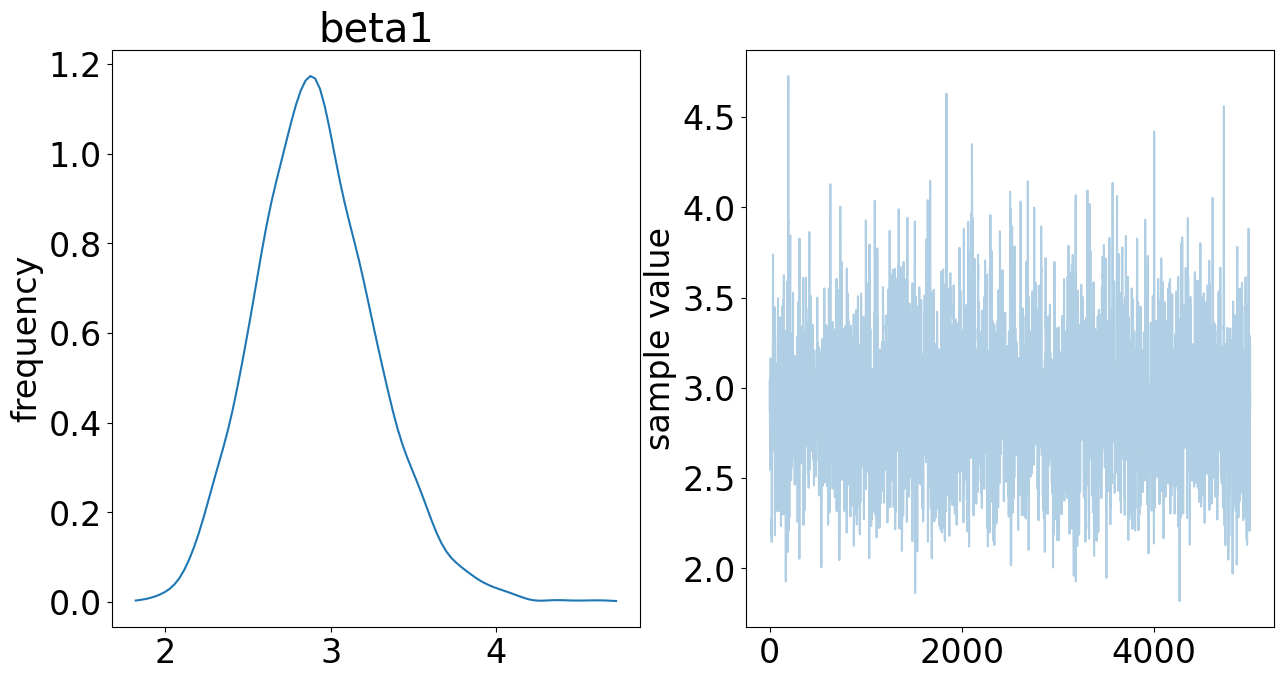

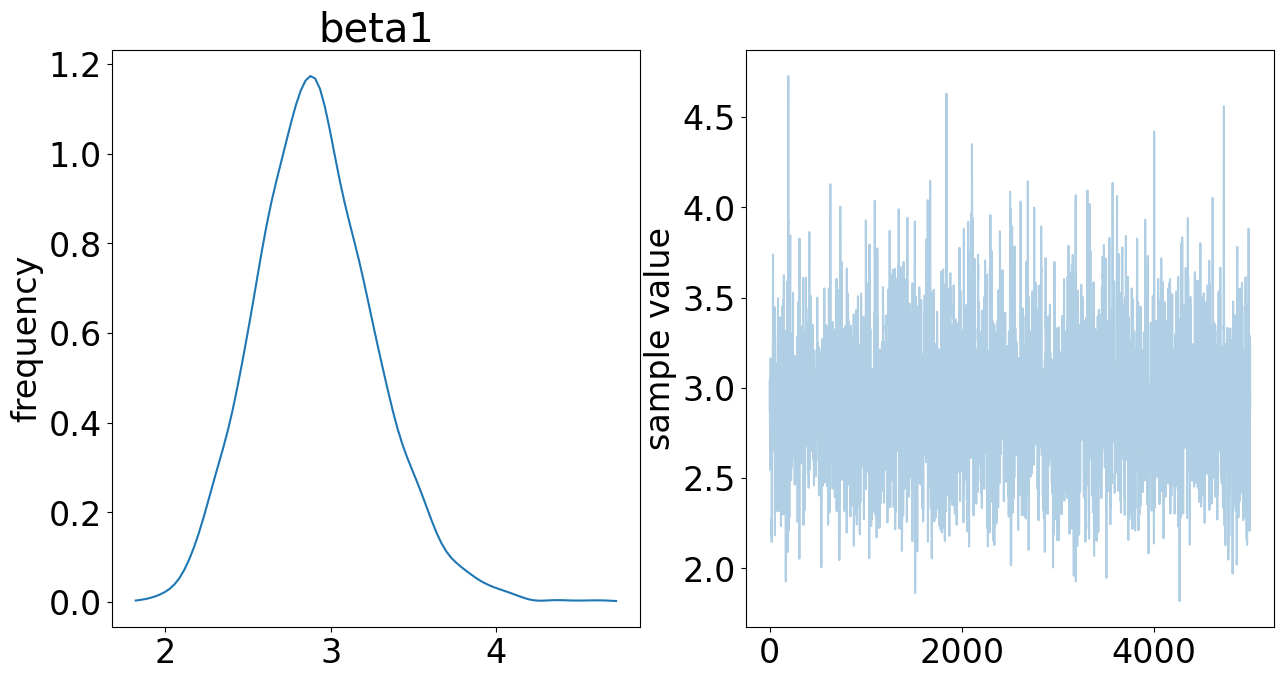

In [9]:
fit.plot()

## Fit variational approximations

In [53]:
# gaussian variational approximation
def lq(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*np.log(2*np.pi*sigma**2)

In [52]:
##########################
##########################
#  optimization wrapper  #
##########################
##########################

def gaussianVI(lp,randp,divergence='rev-kl',B=1000,max_iters=1001,lr_mu=1e-2,lr_lsigma=1e-2):
    """
    This function finds an approximation to p 
    by minimizing the divergence from the family of Gaussians
    using stochastic gradient descent (sgd)
    If you want to minimize the reverse KL, randp can be None - it is only used if divergence=='fwd-kl'
    
    Inputs:
        lp         : function, target log pdf
        randp      : function, target random number generator
        divergence : string, one of 'rev-kl' or 'fwd-kl' indicating divergence to minimize
        B          : int, Monte Carlo sample size for gradient estimation
        max_iters  : int, max number of sgd iterations
        lr_mu      : float, sgd learning rate for the mean
        lr_lsigma  : float, sgd learning rate for the log standard deviation
        
    Outputs:
        mus     : (max_iters,) array, all values of the mean through the optimization
        lsigmas : (max_iters,) array, all values of the log sd through the optimization
    """
    
    # initial values
    mus=np.zeros(max_iters+1)
    mus[0]=np.random.randn() # initialize mu at a draw from std normal (cause 0 is probably the opt, let's make it harder)
    lsigmas=np.zeros(max_iters+1)
    lsigmas[0]=np.random.randn() # ditto

    # optimize
    print('Initial μ: '+str(mus[0]))
    print('Initial σ: '+str(np.exp(lsigmas[0])))
    print()
    print('Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient')
    for t in range(max_iters):
        # calculate gradients
        grad_mu=mu_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
        grad_lsigma=ls_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
    
        # take step
        mus[t+1]=mus[t]-grad_mu*lr_mu/np.sqrt(t+1)
        lsigmas[t+1]=lsigmas[t]-grad_lsigma*lr_lsigma/np.sqrt(t+1)
    
        # do printout
        if t%(max_iters//10)==0: print('  '+str(t)+'   | '+str(mus[t+1])+'   | '+str(np.exp(lsigmas[t+1]))+'   | '+str(grad_mu)+'  | '+str(grad_lsigma))
    # end for
    
    print()
    print('Final μ: '+str(mus[-1]))
    print('Final σ: '+str(np.exp(lsigmas[-1])))
    return mus,lsigmas

##########################
##########################
#       gradients        #
##########################
##########################

def mu_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    # calculate the gradient of the KL w.r.t. the mean mu
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(sample-mu)*np.exp(-2*lsigma))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu))

def ls_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    # calculate the gradient of the KL w.r.t. the log sd lsigma
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(np.exp(-2*lsigma)*(sample-mu)**2-1.))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu)**2-1.)
    
    
##########################
##########################
#     auxiliary fns      #
##########################
##########################
def kl(lq,lp,randq,B=1000):
    # estimate KL(q||p)
    # (for fwd KL simply input lp first and supply a randp sampler instead of randq)
    sample=randq(B)
    return np.mean(lq(sample)-lp(sample))

In [59]:
##########################
##########################
#    posterior defn     #
##########################
##########################
samples_beta1=samples['beta1']
def randp(size): return samples_beta1[:size] # just return the first size Stan samples

### Optimization

In [63]:
##########################
##########################
#    reverse KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=1001
B=5000 # monte carlo sample size for gradient estimation
lr_mu=1e-2
lr_lsigma=1e-1
divergence='rev-kl'

rev_mus,rev_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.27762602098175093   | 0.4457242678349338   | -113.33190274532866  | 5.277328663451465
  100   | 2.618358426834483   | 0.2757892924408296   | -0.7781495254704087  | -0.3402738482448079
  200   | 2.757572781307049   | 0.3068444907964947   | -2.9019864400027866  | -0.5259391306681067
  300   | 2.816333061118728   | 0.3356514434920595   | -3.559475156455125  | -0.5167306847046628
  400   | 2.8519296632043196   | 0.3315026439505787   | -3.465981789687402  | 0.1579321463979928
  500   | 2.8762672232643216   | 0.3467440122608919   | -2.8442300344461926  | 0.6309058980094185
  600   | 2.8785337210794064   | 0.3383817956023507   | 2.0795144755408277  | 0.6089160531483366
  700   | 2.8862187451515147   | 0.34434410127117143   | -0.17850338975059094  | -0.31616631791576044
  800   | 2.8934672460537714   | 0.3427276865793049   | 2.890709

In [64]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

rev_mu=rev_mus[-1]
rev_lsigma=rev_lsigmas[-1]

rev_lq = lambda x : lq(x,rev_mu,rev_lsigma)
rev_randq = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

In [66]:
##########################
##########################
#    forward KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=10001
B=5000 # monte carlo sample size for gradient estimation
lr_mu=1e-1
lr_lsigma=1e-3
divergence='fwd-kl'

fwd_mus,fwd_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.6529934816369699   | 0.7801290486879507   | -7.579515667980677  | -32.02595940853556
  1000   | 2.9154436488524755   | 0.7938698037479929   | -0.0004992045670256431  | 0.7901840070000566
  2000   | 2.9157522363804484   | 0.7777031009909586   | -7.407273574726503e-06  | 0.7813670122124964
  3000   | 2.9157565482059695   | 0.7656402073685286   | -2.5984915414483114e-07  | 0.7744219802712187
  4000   | 2.9157566919740163   | 0.7556980548658848   | -1.4199471462461588e-08  | 0.7684464934330297
  5000   | 2.9157566994880617   | 0.7471086559342403   | -1.0286674822168607e-09  | 0.7630909701896686
  6000   | 2.9157567000111655   | 0.73947832933354   | -9.096676905073764e-11  | 0.7581761565773026
  7000   | 2.9157567000557845   | 0.7325733468985324   | -9.352162066988968e-12  | 0.7535955920762111
  8000   | 2.91575670006022   | 0.726

In [67]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

fwd_mu=fwd_mus[-1]
fwd_lsigma=fwd_lsigmas[-1]

fwd_lq = lambda x : lq(x,fwd_mu,fwd_lsigma)
fwd_randq = lambda B : fwd_mu+np.exp(fwd_lsigma)*np.random.randn(B)

### Diagnostics

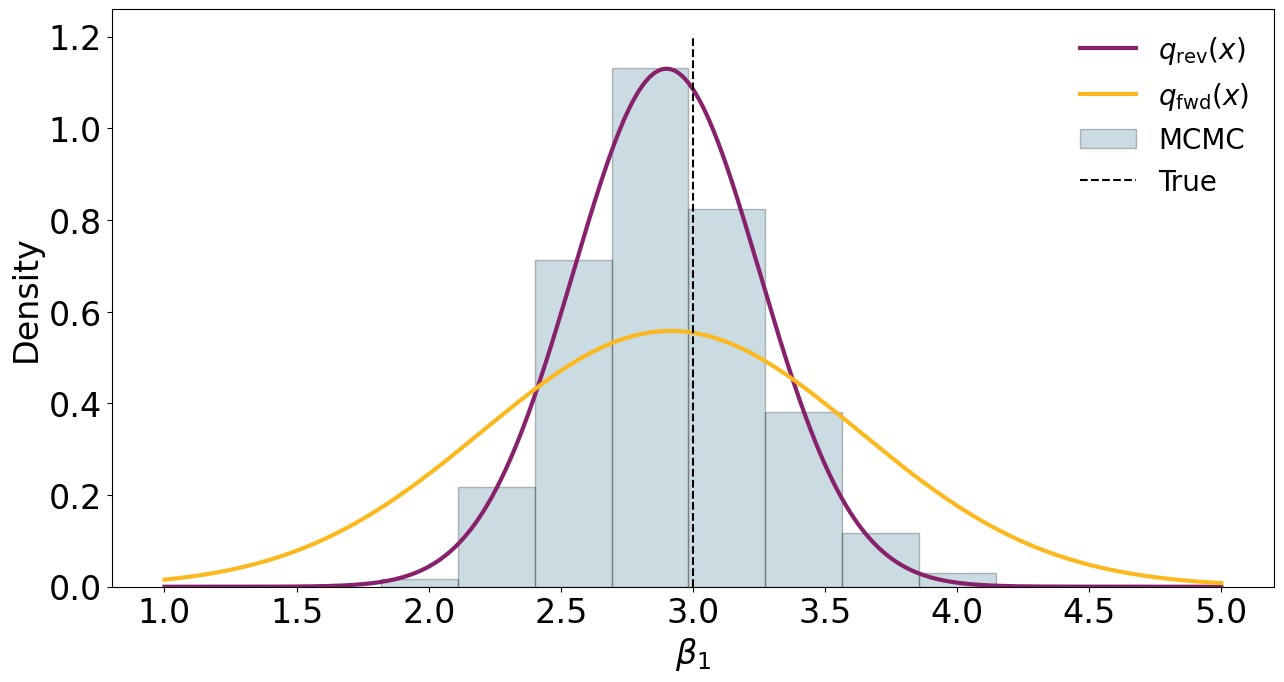

In [68]:
lsx=np.linspace(1,5,1000)
#plt.plot(lsx,lp(lsx),c="black", label=r'$\log p(x)$',lw=3)
plt.plot(lsx,np.exp(rev_lq(lsx)),c='#87216BFF', label=r'$q_{\mathrm{rev}}(x)$',lw=3)
plt.plot(lsx,np.exp(fwd_lq(lsx)),c='#FBB91FFF', label=r'$q_{\mathrm{fwd}}(x)$',lw=3)
plt.hist(samples['beta1'], color='#2D718EFF',ec='black',alpha=0.25,label='MCMC',density=True)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label='True')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
#plt.savefig(figpath + 'logreg_logq.pdf', dpi=300, bbox_inches='tight')